In [32]:
#Imports and definitions TODO: move to a package to clean notebook (?)
#Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et
import requests
import pathlib
import os

#URL's definition
license_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/termsaccepted/Copernicus_General_License'
autorization_url="https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/gettoken"
data_request_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest'
data_status_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/status/{}'
data_result_url="https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/datarequest/jobs/{}/result"
download_order_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder'
download_order_status_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/status/{}'
download_url='https://wekeo-broker.apps.mercator.dpi.wekeo.eu/databroker/dataorder/download/{}'


#JSON request

def make_json(collection_id:str,coordinates:np.ndarray,start_date:str,end_date:str):
  data_request_json={
  "datasetId": collection_id,
  "boundingBoxValues": [
  {
    "name": "bbox",
    "bbox": [
      coordinates[3],
      coordinates[1],
      coordinates[2],
      coordinates[0]
    ]
  }#Maybe improve order 
  ],
  "dateRangeSelectValues": [
  {
    "name": "position",
    "start": start_date,
    "end": end_date
  }
  ],
  "multiStringSelectValues": [
  {
    "name": "variable",
    "value": [
    "MICRO"
    ]
  }
  ],
  "stringChoiceValues": [
  {
    "name": "service",
    "value": "OCEANCOLOUR_GLO_CHL_L3_REP_OBSERVATIONS_009_065-TDS"
  },
  {
    "name": "product",
    "value": "dataset-oc-glo-pft-multi_cci-l3-pft_4km_daily-rep"
  }
  ]
  }
  return data_request_json

def make_download_json(url:str,job_id=str): 
  download_json={
    "uri":url,
    'jobId':job_id
  }
  return make_download_json








# Accessing data with requests
all this should be moved to a function or a client-like package

If first time access, it is necesary to accept licence

In [ ]:
requests.put(license_url, headers=header,data='accepted=true',)

### Define download parameters here

In [30]:
#Define dataset ID
dataset_id="EO:MO:DAT:OCEANCOLOUR_GLO_CHL_L3_REP_OBSERVATIONS_009_065:dataset-oc-glo-pft-multi_cci-l3-pft_4km_daily-rep"
#Define bbox
north=64.96599517253132
south=57.840893953735154
east=13.338878714152687
west=-1.6221298734609302
#Define time range
start="2021-01-01T00:00:00.000Z"
end="2021-01-30T00:00:00.000Z"


##Parsing parameters and creating json TODO: parameters validity check
coordinates=np.array([north,south,east,west])
request_json=make_json(dataset_id,coordinates,start,end)



Get token and building headers

In [ ]:
r=requests.get(autorization_url,auth=('<uername>','<passowrd>'))
token=r.json()['access_token']
header = {"Authorization" : "Basic {}".format(token)}
json_header={"Authorization" : "Basic {}".format(token),'content-type':'application/json'}

Requesting data and geting job id

In [ ]:
r=requests.post(data_request_url,headers=json_header,json=request_json)
job_id=r.json()['jobId']

Checking job status

In [ ]:
r=requests.get(data_status_url.format(job_id),headers=header)
r.json()


Once status completed, bet download information

In [ ]:
r=requests.get(data_result_url.format(job_id),headers=header)
dowload_json=make_download_json(r.json()['content'][0]['url'],job_id)


Order data and get order id


In [ ]:
r=requests.post(download_order_url,headers=json_header,json=dowload_json)
orderId=r.json()['orderId']

Check order status

In [ ]:
r=requests.get(download_order_status_url.format(orderId),headers=header)
r.content()

Once completed, download 

In [ ]:
#TODO automatically create name and define working path before
name='dataset-oc-glo-pft-multi_cci-l3-pft_4km_daily-rep_1655499191755.nc'
path = pathlib.Path(os.path.join(r'C:\Users\jegom\Desktop\clorop', name))
print('downloading {} to {}'.format(name, path))
with open(path, 'wb') as f:
    r=requests.get(download_url,headers=header)
    f.write(r.content)


# (Very)Basic data reading and manipulation

Reading dara as rioxarray

In [33]:
data=rxr.open_rasterio(r"C:\Users\jegom\Desktop\clorop\dataset-oc-glo-pft-multi_cci-l3-pft_4km_daily-rep_1655499191755.nc",mask_and_scale=True)
data

<xarray.Dataset>
Dimensions:      (time: 30, x: 1531, y: 906)
Coordinates:
  * time         (time) object 2021-04-01 00:00:00 ... 2021-04-30 00:00:00
  * x            (x) float64 -1.631 -1.625 -1.619 -1.614 ... 6.858 6.864 6.869
  * y            (y) float64 62.95 62.94 62.94 62.93 ... 57.94 57.93 57.93 57.92
    spatial_ref  int32 0
Data variables:
    CHL          (time, y, x) float32 ...
Attributes: (12/104)
    CHL#coordinates:                time lat lon 
    CHL#input_files_reprocessings:  Processors versions: OLCIA 07.02NR/OLCIB ...
    CHL#long_name:                  Chlorophyll concentration - Mean of the b...
    CHL#missing_value:              -999
    CHL#pct_characterised_error:    50
    CHL#standard_name:              mass_concentration_of_chlorophyll_a_in_se...
    ...                             ...
    time#standard_name:             time
    time#units:                     days since 1900-01-01 00:00:00
    time#valid_max:                 401767
    time#valid_min:                 0
    time#_ChunkSizes:               1
    time#_CoordinateAxisType:       Time

Ploting average CHL concentration as time series

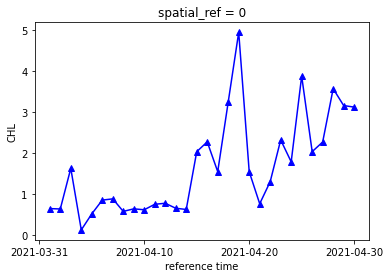

In [3]:
mean_concentration=np.mean(data['CHL'],axis=(1,2))
mean_concentration.plot.line("b-^")
plt.show()

Plotting CLH area (every pixel with no data value is considered and 4m resolution is assumed (?))

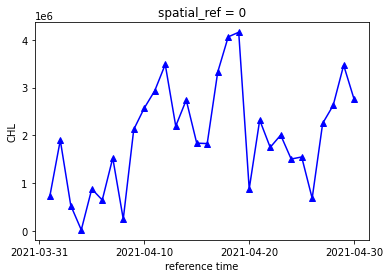

In [23]:
area=np.sum(data['CHL'].notnull()*4,axis=(1,2))
area.plot.line("b-^")

Este plot de mapa hay que verlo bien

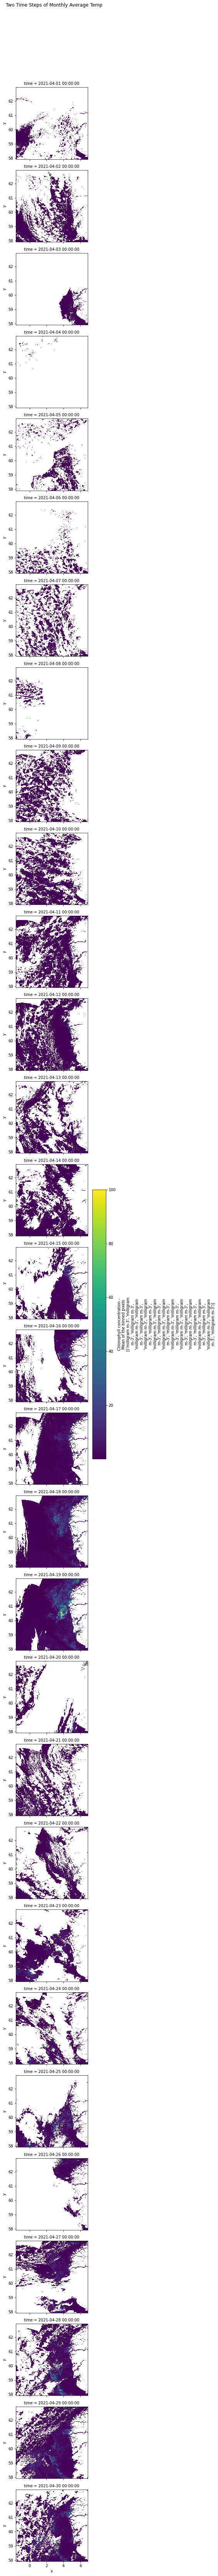

In [38]:
data['CHL'].plot(x="x",
                      y="y",
                      col="time",
                      col_wrap=1)
plt.suptitle("Two Time Steps of Monthly Average Temp", y=1.03)
plt.show()